# version 6: 剩下想要看 gradient vanish throught sigmoid vs. relu

參數： 

* cpu
* ***batch_size = 1280***
* epochs = 30
* hidden_units = 64
* ***控制 1: um_layers= layers_list = [5, 6, 7, 8, 9, 10, 11]***
* lr_list = [0.001]
* ***控制 2: act_list = ['relu', 'sigmoid']***
* opt_list = ['adam']

Using device: cpu

=== 訓練：5層, activation=relu ===

=== 訓練：6層, activation=relu ===

=== 訓練：7層, activation=relu ===

=== 訓練：8層, activation=relu ===

=== 訓練：9層, activation=relu ===

=== 訓練：10層, activation=relu ===

=== 訓練：11層, activation=relu ===

=== 訓練：5層, activation=sigmoid ===

=== 訓練：6層, activation=sigmoid ===

=== 訓練：7層, activation=sigmoid ===

=== 訓練：8層, activation=sigmoid ===

=== 訓練：9層, activation=sigmoid ===

=== 訓練：10層, activation=sigmoid ===

=== 訓練：11層, activation=sigmoid ===


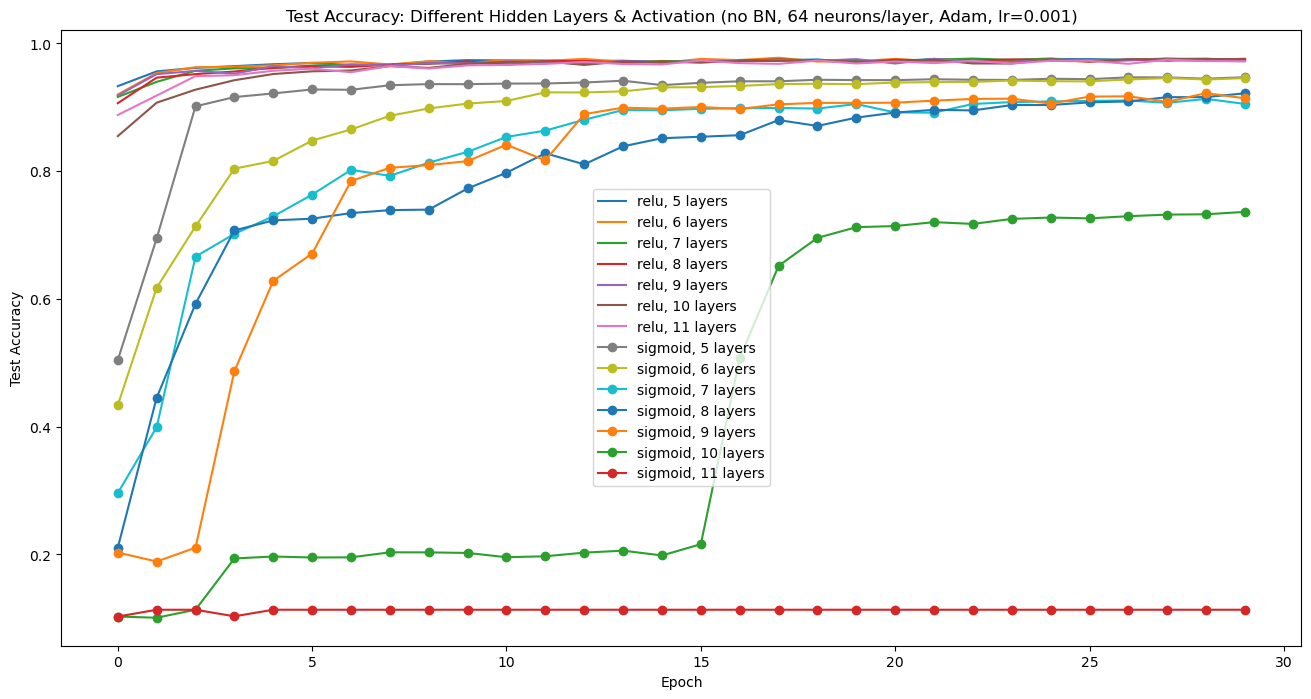

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==== 1. 參數設定 ====
batch_size = 128
epochs = 30
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print("Using device:", device)

# ==== 2. 數據預處理 ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST 標準化
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==== 3. 定義 DNN（無 BN，hidden_units=64，可調整層數） ====
class DNN(nn.Module):
    def __init__(self, num_layers=3, activation='relu'):
        super().__init__()
        input_dim = 28*28
        hidden_units = 64
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError('Only relu or sigmoid supported')
            input_dim = hidden_units
        layers.append(nn.Linear(hidden_units, 10))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# ==== 4. 訓練與測試函數 ====
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# ==== 5. 實驗四：比較 hidden layers 數 & activation ====
def exp_layers_vs_activation(layers_list, act_list):
    plt.figure(figsize=(16, 8))
    for activation in act_list:
        for num_layers in layers_list:
            print(f"\n=== 訓練：{num_layers}層, activation={activation} ===")
            model = DNN(num_layers=num_layers, activation=activation).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()
            test_accs = []
            for epoch in range(epochs):
                train(model, train_loader, optimizer, criterion)
                _, test_acc = evaluate(model, test_loader, criterion)
                test_accs.append(test_acc)
            label = f'{activation}, {num_layers} layers'
            if activation == 'sigmoid':
                plt.plot(test_accs, label=label, marker='o')  # 用圓圈
            else:
                plt.plot(test_accs, label=label)              # 默認線
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Different Hidden Layers & Activation (no BN, 64 neurons/layer, Adam, lr=0.001)')
    plt.legend()
    plt.show()

# ==== 執行實驗四 ====
layers_list = [5, 6, 7, 8, 9, 10, 11]
act_list = ['relu', 'sigmoid']
exp_layers_vs_activation(layers_list, act_list)


Using device: cpu

=== 訓練：activation=relu ===

=== 訓練：activation=sigmoid ===


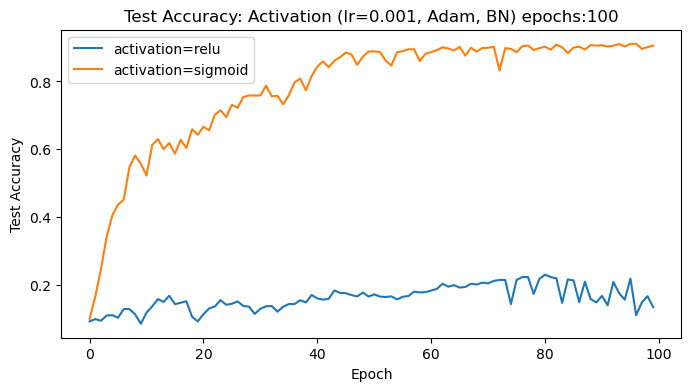

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==== 1. 參數設定 ====
batch_size = 1280
epochs = 100
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# ==== 2. 數據預處理 ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST 標準化
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==== 3. 定義 DNN with BN ==== 40層
class DNN(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        input_dim = 28*28
        hidden_units = 6
        num_layers = 40
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError('Only relu or sigmoid supported')
            input_dim = hidden_units
        layers.append(nn.Linear(hidden_units, 10))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# ==== 4. 訓練與測試函數 ====
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# ==== 5-1. 實驗一：不同 learning rate 比較 ====
def exp_learning_rate(lr_list):
    results = {}
    for lr in lr_list:
        label = f'lr={lr}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(10,5))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Different Learning Rates (Adam, ReLU, BN)  epochs:100')
    plt.legend()
    plt.show()

# ==== 5-2. 實驗二：activation (sigmoid vs relu) ====
def exp_activation(act_list):
    results = {}
    for act in act_list:
        label = f'activation={act}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation=act).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Activation (lr=0.001, Adam, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 5-3. 實驗三：optimizer 比較 (adam, sgd, rmsprop) ====
def exp_optimizer(opt_list):
    results = {}
    for opt_name in opt_list:
        label = f'optimizer={opt_name}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        if opt_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        elif opt_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=0.001)
        elif opt_name == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        else:
            raise ValueError('Only adam, sgd, rmsprop supported')
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Optimizer (lr=0.001, ReLU, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 6. 執行三組實驗 ====

# 2. Activation 比較
act_list = ['relu', 'sigmoid']
exp_activation(act_list)



# version 4: 剩下想要看 gradient vanish

參數： 

* cpu
* batch_size = 128
* epochs = 100
* hidden_units = 6
* ***num_layers= 30***
* lr_list = [0.001]
* ***控制 : act_list = ['relu', 'sigmoid']***
* opt_list = ['adam']

Using device: cpu

=== 訓練：activation=relu ===

=== 訓練：activation=sigmoid ===


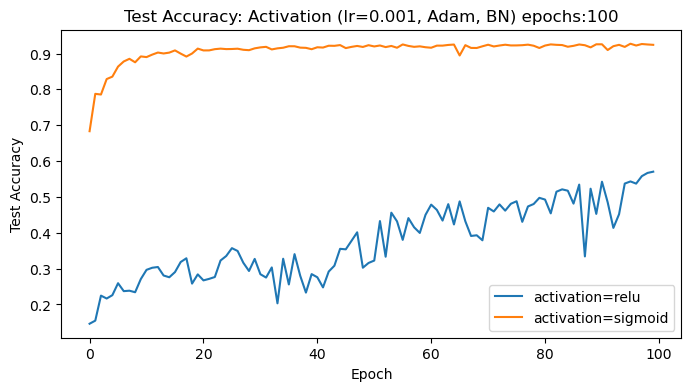

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==== 1. 參數設定 ====
batch_size = 128
epochs = 100
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# ==== 2. 數據預處理 ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST 標準化
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==== 3. 定義 DNN with BN ==== 二十層
class DNN(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        input_dim = 28*28
        hidden_units = 6
        num_layers = 30
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError('Only relu or sigmoid supported')
            input_dim = hidden_units
        layers.append(nn.Linear(hidden_units, 10))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# ==== 4. 訓練與測試函數 ====
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# ==== 5-1. 實驗一：不同 learning rate 比較 ====
def exp_learning_rate(lr_list):
    results = {}
    for lr in lr_list:
        label = f'lr={lr}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(10,5))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Different Learning Rates (Adam, ReLU, BN)  epochs:100')
    plt.legend()
    plt.show()

# ==== 5-2. 實驗二：activation (sigmoid vs relu) ====
def exp_activation(act_list):
    results = {}
    for act in act_list:
        label = f'activation={act}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation=act).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Activation (lr=0.001, Adam, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 5-3. 實驗三：optimizer 比較 (adam, sgd, rmsprop) ====
def exp_optimizer(opt_list):
    results = {}
    for opt_name in opt_list:
        label = f'optimizer={opt_name}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        if opt_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        elif opt_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=0.001)
        elif opt_name == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        else:
            raise ValueError('Only adam, sgd, rmsprop supported')
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Optimizer (lr=0.001, ReLU, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 6. 執行三組實驗 ====


# 2. Activation 比較
act_list = ['relu', 'sigmoid']
exp_activation(act_list)



# version 3: 我們將網路拉長，想看 sigmoid vs. relu


參數： 

* cpu
* batch_size = 128
* epochs = 100
* hidden_units = 6
* ***num_layers = 20***
* 控制 1: lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
* lr = 1 訓練不起來
* lr = 0.1 震盪
* 控制 2: act_list = ['relu', 'sigmoid']
* 控制 3: opt_list = ['adam', 'sgd', 'rmsprop']

Using device: cpu

=== 訓練：lr=1 ===

=== 訓練：lr=0.1 ===

=== 訓練：lr=0.01 ===

=== 訓練：lr=0.001 ===

=== 訓練：lr=0.0001 ===


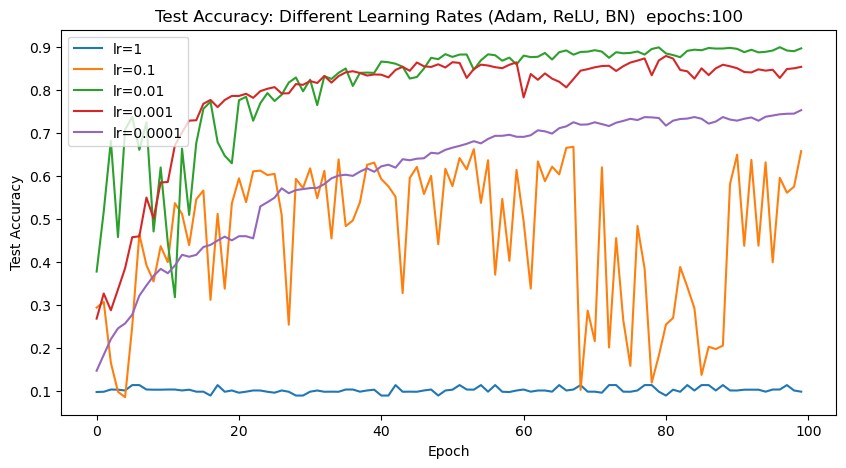


=== 訓練：activation=relu ===

=== 訓練：activation=sigmoid ===


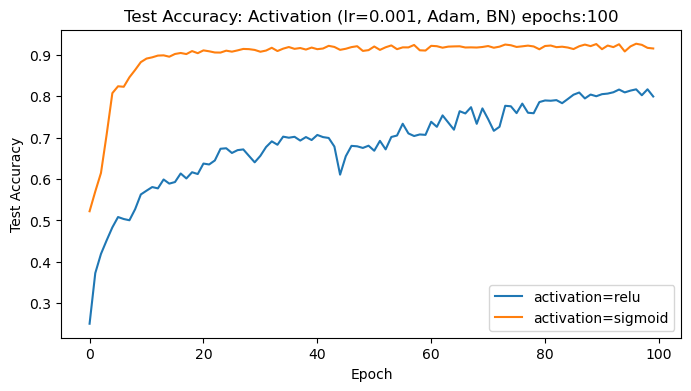


=== 訓練：optimizer=adam ===

=== 訓練：optimizer=sgd ===

=== 訓練：optimizer=rmsprop ===


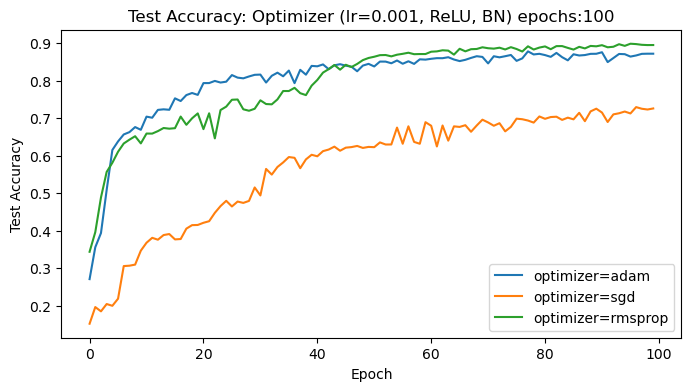

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==== 1. 參數設定 ====
batch_size = 128
epochs = 100
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# ==== 2. 數據預處理 ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST 標準化
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==== 3. 定義 DNN with BN ==== 二十層
class DNN(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        input_dim = 28*28
        hidden_units = 6
        num_layers = 20
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError('Only relu or sigmoid supported')
            input_dim = hidden_units
        layers.append(nn.Linear(hidden_units, 10))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# ==== 4. 訓練與測試函數 ====
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# ==== 5-1. 實驗一：不同 learning rate 比較 ====
def exp_learning_rate(lr_list):
    results = {}
    for lr in lr_list:
        label = f'lr={lr}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(10,5))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Different Learning Rates (Adam, ReLU, BN)  epochs:100')
    plt.legend()
    plt.show()

# ==== 5-2. 實驗二：activation (sigmoid vs relu) ====
def exp_activation(act_list):
    results = {}
    for act in act_list:
        label = f'activation={act}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation=act).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Activation (lr=0.001, Adam, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 5-3. 實驗三：optimizer 比較 (adam, sgd, rmsprop) ====
def exp_optimizer(opt_list):
    results = {}
    for opt_name in opt_list:
        label = f'optimizer={opt_name}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        if opt_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        elif opt_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=0.001)
        elif opt_name == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        else:
            raise ValueError('Only adam, sgd, rmsprop supported')
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            #print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Optimizer (lr=0.001, ReLU, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 6. 執行三組實驗 ====

# 1. Learning rate 比較
lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
exp_learning_rate(lr_list)

# 2. Activation 比較
act_list = ['relu', 'sigmoid']
exp_activation(act_list)

# 3. Optimizer 比較
opt_list = ['adam', 'sgd', 'rmsprop']
exp_optimizer(opt_list)


# version 2: 起點

如果用 epochs = 20 可能會看不見一些趨勢, 所以修正成 100 來看趨勢

參數： 

* cpu
* batch_size = 128
* ***epochs = 100*** 
* hidden_units = 6
* num_layers = 10
* 控制 1: lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
* 控制 2: act_list = ['relu', 'sigmoid']
* 控制 3: opt_list = ['adam', 'sgd', 'rmsprop']

Using device: cpu

=== 訓練：lr=1 ===
Epoch 1/100 | Train acc: 0.0995 | Test acc: 0.0892
Epoch 2/100 | Train acc: 0.1027 | Test acc: 0.1010
Epoch 3/100 | Train acc: 0.1022 | Test acc: 0.1028
Epoch 4/100 | Train acc: 0.1025 | Test acc: 0.0974
Epoch 5/100 | Train acc: 0.1007 | Test acc: 0.0974
Epoch 6/100 | Train acc: 0.1001 | Test acc: 0.0982
Epoch 7/100 | Train acc: 0.1022 | Test acc: 0.1009
Epoch 8/100 | Train acc: 0.1028 | Test acc: 0.1135
Epoch 9/100 | Train acc: 0.0998 | Test acc: 0.1009
Epoch 10/100 | Train acc: 0.1014 | Test acc: 0.0982
Epoch 11/100 | Train acc: 0.1027 | Test acc: 0.0980
Epoch 12/100 | Train acc: 0.1032 | Test acc: 0.1010
Epoch 13/100 | Train acc: 0.1013 | Test acc: 0.0974
Epoch 14/100 | Train acc: 0.1008 | Test acc: 0.1009
Epoch 15/100 | Train acc: 0.0997 | Test acc: 0.1135
Epoch 16/100 | Train acc: 0.1019 | Test acc: 0.1009
Epoch 17/100 | Train acc: 0.1012 | Test acc: 0.0892
Epoch 18/100 | Train acc: 0.1022 | Test acc: 0.0974
Epoch 19/100 | Train acc: 0.1028 | Tes

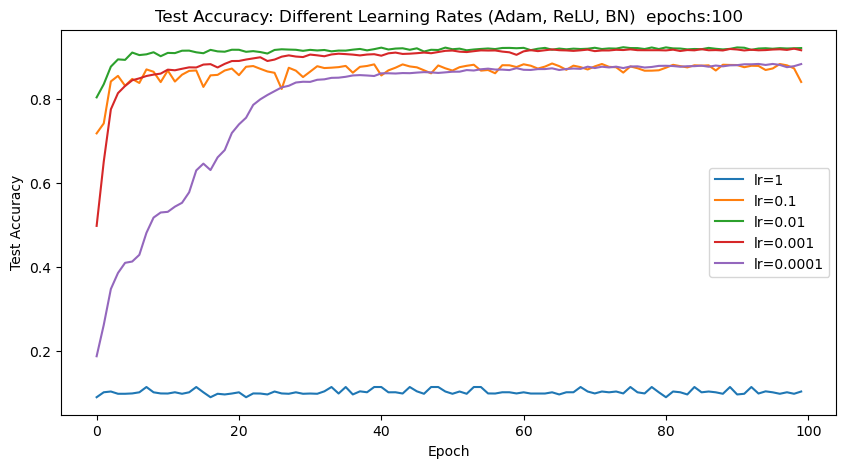


=== 訓練：activation=relu ===
Epoch 1/100 | Train acc: 0.3513 | Test acc: 0.5144
Epoch 2/100 | Train acc: 0.6241 | Test acc: 0.7490
Epoch 3/100 | Train acc: 0.7137 | Test acc: 0.7584
Epoch 4/100 | Train acc: 0.7568 | Test acc: 0.8153
Epoch 5/100 | Train acc: 0.7946 | Test acc: 0.8310
Epoch 6/100 | Train acc: 0.8143 | Test acc: 0.8481
Epoch 7/100 | Train acc: 0.8213 | Test acc: 0.8444
Epoch 8/100 | Train acc: 0.8289 | Test acc: 0.8593
Epoch 9/100 | Train acc: 0.8339 | Test acc: 0.8598
Epoch 10/100 | Train acc: 0.8372 | Test acc: 0.8586
Epoch 11/100 | Train acc: 0.8424 | Test acc: 0.8711
Epoch 12/100 | Train acc: 0.8475 | Test acc: 0.8662
Epoch 13/100 | Train acc: 0.8517 | Test acc: 0.8760
Epoch 14/100 | Train acc: 0.8574 | Test acc: 0.8785
Epoch 15/100 | Train acc: 0.8586 | Test acc: 0.8811
Epoch 16/100 | Train acc: 0.8609 | Test acc: 0.8796
Epoch 17/100 | Train acc: 0.8674 | Test acc: 0.8831
Epoch 18/100 | Train acc: 0.8652 | Test acc: 0.8835
Epoch 19/100 | Train acc: 0.8667 | Test acc: 

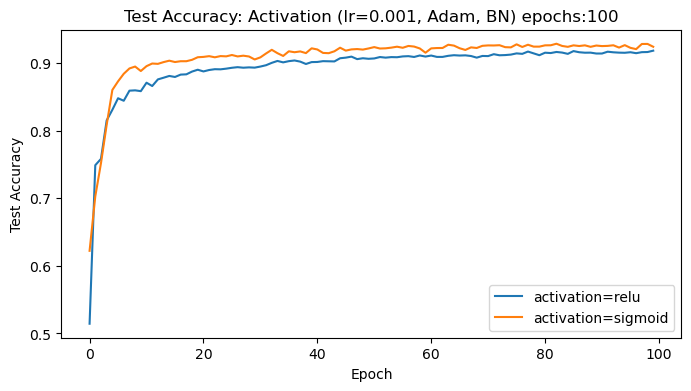


=== 訓練：optimizer=adam ===
Epoch 1/100 | Train acc: 0.3660 | Test acc: 0.4707
Epoch 2/100 | Train acc: 0.5265 | Test acc: 0.6140
Epoch 3/100 | Train acc: 0.6159 | Test acc: 0.6317
Epoch 4/100 | Train acc: 0.6841 | Test acc: 0.7238
Epoch 5/100 | Train acc: 0.7205 | Test acc: 0.7778
Epoch 6/100 | Train acc: 0.7810 | Test acc: 0.8041
Epoch 7/100 | Train acc: 0.7970 | Test acc: 0.8241
Epoch 8/100 | Train acc: 0.8134 | Test acc: 0.8432
Epoch 9/100 | Train acc: 0.8300 | Test acc: 0.8529
Epoch 10/100 | Train acc: 0.8407 | Test acc: 0.8556
Epoch 11/100 | Train acc: 0.8448 | Test acc: 0.8600
Epoch 12/100 | Train acc: 0.8494 | Test acc: 0.8652
Epoch 13/100 | Train acc: 0.8539 | Test acc: 0.8682
Epoch 14/100 | Train acc: 0.8569 | Test acc: 0.8682
Epoch 15/100 | Train acc: 0.8579 | Test acc: 0.8702
Epoch 16/100 | Train acc: 0.8600 | Test acc: 0.8748
Epoch 17/100 | Train acc: 0.8611 | Test acc: 0.8759
Epoch 18/100 | Train acc: 0.8647 | Test acc: 0.8776
Epoch 19/100 | Train acc: 0.8670 | Test acc: 0

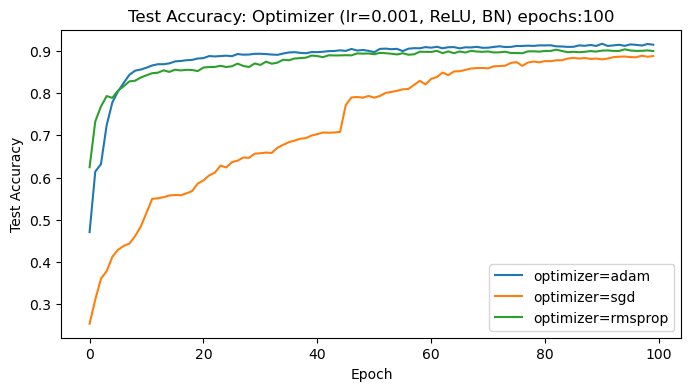

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==== 1. 參數設定 ====
batch_size = 128
epochs = 100
#device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# ==== 2. 數據預處理 ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST 標準化
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==== 3. 定義 DNN with BN ==== 十層
class DNN(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        input_dim = 28*28
        hidden_units = 6
        num_layers = 10
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError('Only relu or sigmoid supported')
            input_dim = hidden_units
        layers.append(nn.Linear(hidden_units, 10))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# ==== 4. 訓練與測試函數 ====
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# ==== 5-1. 實驗一：不同 learning rate 比較 ====
def exp_learning_rate(lr_list):
    results = {}
    for lr in lr_list:
        label = f'lr={lr}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(10,5))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Different Learning Rates (Adam, ReLU, BN)  epochs:100')
    plt.legend()
    plt.show()

# ==== 5-2. 實驗二：activation (sigmoid vs relu) ====
def exp_activation(act_list):
    results = {}
    for act in act_list:
        label = f'activation={act}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation=act).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Activation (lr=0.001, Adam, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 5-3. 實驗三：optimizer 比較 (adam, sgd, rmsprop) ====
def exp_optimizer(opt_list):
    results = {}
    for opt_name in opt_list:
        label = f'optimizer={opt_name}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        if opt_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        elif opt_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=0.001)
        elif opt_name == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        else:
            raise ValueError('Only adam, sgd, rmsprop supported')
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Optimizer (lr=0.001, ReLU, BN) epochs:100')
    plt.legend()
    plt.show()

# ==== 6. 執行三組實驗 ====

# 1. Learning rate 比較
lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
exp_learning_rate(lr_list)

# 2. Activation 比較
act_list = ['relu', 'sigmoid']
exp_activation(act_list)

# 3. Optimizer 比較
opt_list = ['adam', 'sgd', 'rmsprop']
exp_optimizer(opt_list)


# version 1: 起點

如果用 epochs = 20 可能會看不見一些趨勢

參數： 

* cpu
* batch_size = 128
* epochs = 20 
* hidden_units = 6
* num_layers = 10
* 控制 1: lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
* 控制 2: act_list = ['relu', 'sigmoid']
* 控制 3: opt_list = ['adam', 'sgd', 'rmsprop']



Using device: cpu

=== 訓練：lr=1 ===
Epoch 1/20 | Train acc: 0.1014 | Test acc: 0.1028
Epoch 2/20 | Train acc: 0.1011 | Test acc: 0.0958
Epoch 3/20 | Train acc: 0.1020 | Test acc: 0.1010
Epoch 4/20 | Train acc: 0.1020 | Test acc: 0.1135
Epoch 5/20 | Train acc: 0.1012 | Test acc: 0.1010
Epoch 6/20 | Train acc: 0.0997 | Test acc: 0.1135
Epoch 7/20 | Train acc: 0.1029 | Test acc: 0.1135
Epoch 8/20 | Train acc: 0.0998 | Test acc: 0.1028
Epoch 9/20 | Train acc: 0.0998 | Test acc: 0.1028
Epoch 10/20 | Train acc: 0.1018 | Test acc: 0.1135
Epoch 11/20 | Train acc: 0.1019 | Test acc: 0.1135
Epoch 12/20 | Train acc: 0.1017 | Test acc: 0.1028
Epoch 13/20 | Train acc: 0.1019 | Test acc: 0.1009
Epoch 14/20 | Train acc: 0.0999 | Test acc: 0.0892
Epoch 15/20 | Train acc: 0.1016 | Test acc: 0.0974
Epoch 16/20 | Train acc: 0.1030 | Test acc: 0.1135
Epoch 17/20 | Train acc: 0.1011 | Test acc: 0.0958
Epoch 18/20 | Train acc: 0.1010 | Test acc: 0.1028
Epoch 19/20 | Train acc: 0.1027 | Test acc: 0.0892
Epoch

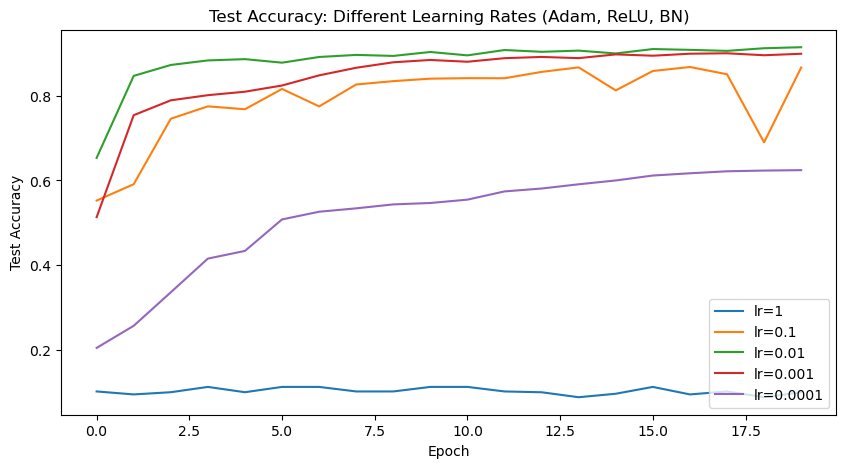


=== 訓練：activation=relu ===
Epoch 1/20 | Train acc: 0.4332 | Test acc: 0.5866
Epoch 2/20 | Train acc: 0.6421 | Test acc: 0.7354
Epoch 3/20 | Train acc: 0.7526 | Test acc: 0.7966
Epoch 4/20 | Train acc: 0.7866 | Test acc: 0.8180
Epoch 5/20 | Train acc: 0.8081 | Test acc: 0.8343
Epoch 6/20 | Train acc: 0.8269 | Test acc: 0.8543
Epoch 7/20 | Train acc: 0.8435 | Test acc: 0.8700
Epoch 8/20 | Train acc: 0.8513 | Test acc: 0.8794
Epoch 9/20 | Train acc: 0.8605 | Test acc: 0.8832
Epoch 10/20 | Train acc: 0.8622 | Test acc: 0.8843
Epoch 11/20 | Train acc: 0.8663 | Test acc: 0.8842
Epoch 12/20 | Train acc: 0.8693 | Test acc: 0.8879
Epoch 13/20 | Train acc: 0.8703 | Test acc: 0.8845
Epoch 14/20 | Train acc: 0.8733 | Test acc: 0.8904
Epoch 15/20 | Train acc: 0.8757 | Test acc: 0.8875
Epoch 16/20 | Train acc: 0.8772 | Test acc: 0.8929
Epoch 17/20 | Train acc: 0.8776 | Test acc: 0.8972
Epoch 18/20 | Train acc: 0.8817 | Test acc: 0.9006
Epoch 19/20 | Train acc: 0.8825 | Test acc: 0.8979
Epoch 20/20 

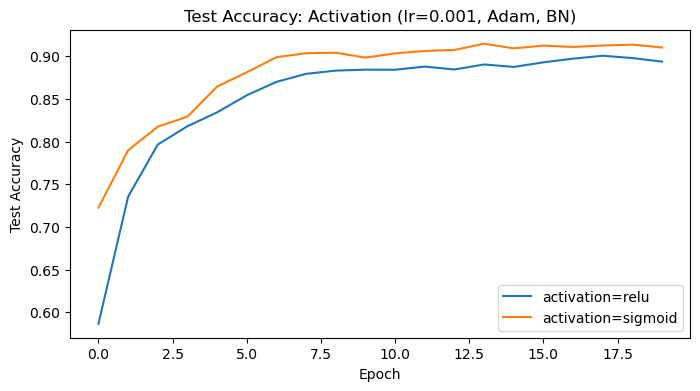


=== 訓練：optimizer=adam ===
Epoch 1/20 | Train acc: 0.3745 | Test acc: 0.5474
Epoch 2/20 | Train acc: 0.5557 | Test acc: 0.5704
Epoch 3/20 | Train acc: 0.6064 | Test acc: 0.6522
Epoch 4/20 | Train acc: 0.6666 | Test acc: 0.7030
Epoch 5/20 | Train acc: 0.7240 | Test acc: 0.8055
Epoch 6/20 | Train acc: 0.8088 | Test acc: 0.8458
Epoch 7/20 | Train acc: 0.8354 | Test acc: 0.8686
Epoch 8/20 | Train acc: 0.8494 | Test acc: 0.8717
Epoch 9/20 | Train acc: 0.8585 | Test acc: 0.8834
Epoch 10/20 | Train acc: 0.8644 | Test acc: 0.8857
Epoch 11/20 | Train acc: 0.8692 | Test acc: 0.8886
Epoch 12/20 | Train acc: 0.8725 | Test acc: 0.8866
Epoch 13/20 | Train acc: 0.8749 | Test acc: 0.8913
Epoch 14/20 | Train acc: 0.8780 | Test acc: 0.8911
Epoch 15/20 | Train acc: 0.8770 | Test acc: 0.8949
Epoch 16/20 | Train acc: 0.8798 | Test acc: 0.8958
Epoch 17/20 | Train acc: 0.8804 | Test acc: 0.9000
Epoch 18/20 | Train acc: 0.8819 | Test acc: 0.8965
Epoch 19/20 | Train acc: 0.8835 | Test acc: 0.8967
Epoch 20/20 |

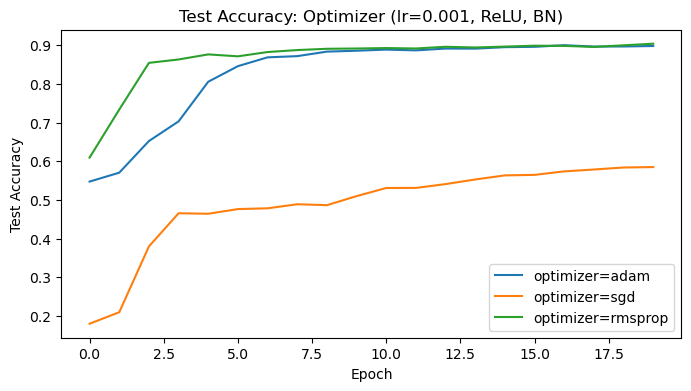

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==== 1. 參數設定 ====
batch_size = 128
epochs = 20
#device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# ==== 2. 數據預處理 ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST 標準化
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==== 3. 定義 DNN with BN ====
class DNN(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        input_dim = 28*28
        hidden_units = 6
        num_layers = 10
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError('Only relu or sigmoid supported')
            input_dim = hidden_units
        layers.append(nn.Linear(hidden_units, 10))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# ==== 4. 訓練與測試函數 ====
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# ==== 5-1. 實驗一：不同 learning rate 比較 ====
def exp_learning_rate(lr_list):
    results = {}
    for lr in lr_list:
        label = f'lr={lr}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(10,5))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Different Learning Rates (Adam, ReLU, BN)')
    plt.legend()
    plt.show()

# ==== 5-2. 實驗二：activation (sigmoid vs relu) ====
def exp_activation(act_list):
    results = {}
    for act in act_list:
        label = f'activation={act}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation=act).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Activation (lr=0.001, Adam, BN)')
    plt.legend()
    plt.show()

# ==== 5-3. 實驗三：optimizer 比較 (adam, sgd, rmsprop) ====
def exp_optimizer(opt_list):
    results = {}
    for opt_name in opt_list:
        label = f'optimizer={opt_name}'
        print(f"\n=== 訓練：{label} ===")
        model = DNN(activation='relu').to(device)
        if opt_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        elif opt_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=0.001)
        elif opt_name == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        else:
            raise ValueError('Only adam, sgd, rmsprop supported')
        criterion = nn.CrossEntropyLoss()
        train_accs, test_accs = [], []
        for epoch in range(epochs):
            _, train_acc = train(model, train_loader, optimizer, criterion)
            _, test_acc = evaluate(model, test_loader, criterion)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f"Epoch {epoch+1}/{epochs} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        results[label] = test_accs
    plt.figure(figsize=(8,4))
    for label, accs in results.items():
        plt.plot(accs, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Optimizer (lr=0.001, ReLU, BN)')
    plt.legend()
    plt.show()

# ==== 6. 執行三組實驗 ====

# 1. Learning rate 比較
lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
exp_learning_rate(lr_list)

# 2. Activation 比較
act_list = ['relu', 'sigmoid']
exp_activation(act_list)

# 3. Optimizer 比較
opt_list = ['adam', 'sgd', 'rmsprop']
exp_optimizer(opt_list)
